# Forecasting Notebook

This Notebook will demonstrate the Bayesian forecasting method that will be used to predict future EPEX prices for the battery charging optimisation.


In [1]:
import sys  # noqa: E402
sys.path.append("../")
import matplotlib.pyplot as plt
from Hack import load
from Forecasting import Bayesian_Forecast

%load_ext autoreload
%autoreload 2

First the EPEX data is loaded in.

In [2]:
# Load the data
epex = load.epex().load()



* The foreacsting model is then utilised.
* See the "Forecasting/Bayesian_Forecast.py" module for more detail.
    * The model starts forecasting from the array index "forecast_start_index" and end at "forecast_end_index".
    * It builds a prior based upon the previous "prior_length" data points and uses that to predict the next "horizon" data points.
        * We have chosen to predict the next 3 hours of prices based upon the last 24 hours of data (horizon of 6 means 6 half hours).
    * "nsamps" is the number of samples drawn from the forecast distribution. More samples will increase accuracy of the prediction (assuming a good prior), while also increasing run time.
    * "rho" is a random factor that will increase the variance of the forecast. This can prevent over-training based upon random variance in the prior data.


* The returns of the "evaulate" function are as follows:
    * "datetimes" is an aray of datetime objects corresponding to the time and date of the EPEX data.
    * "prices" are the EPEX price at each "datetimes".
    * "samples" is an array of size [nsamps, size(datetimes), horizon]. This is array of all "nsamps" samples (zeroth index), at every time (first index), used to predict the price in the future by a certain amount of time (second index). e.g. samples[:,10,2], will give an array of all "nsamps" points used to predict the price 1.5 hours in the future from the 10th EPEX data_point.
    * "forecast" is an array of size [# epex data points, horizon]. This array gives the median of the samples array, which is the forecasted price. i.e. forecast[10,2] gives the price prediction based upon the prior up to time 10, 1.5 hours in the future. 

In [3]:
#Obtain the foreacsted samples and data
horizon = 6

datetimes,prices,samples,forecast = Bayesian_Forecast.evaluate(epex,
    horizon=horizon,
    forecast_start_index=0,
    forecast_end_index=-1,
    prior_length=48,
    nsamps=500,
    rho=0.3
)


* We shall now plot some section of this forecasted data.
    * "plot_start" is the index at which to begin the forecast plot.
    * "plot_length" is how many half hour EPEX prices alongside predictions it will show.
    * Some useful dates are below:
        * 4994 is 00:00 14th July 2020
        * 14978 is 00:00 7th Feb 2020
        * 30002 is 00:00 16th Dec 2020
        * 45362 is 00:00 1st November 2021

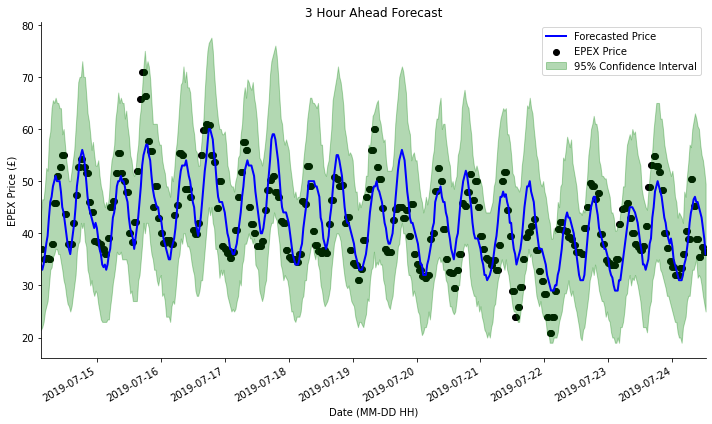

In [4]:
starts = [4994,14978,30002,45362]

plot_start = starts[0] #Offset from the start date at which to begin the plot
plot_length = 500

fig, ax = plt.subplots(figsize=(10,6))
ax = Bayesian_Forecast.plot_forecast(
    fig, ax,
    epex=epex,
    datetimes=datetimes,
    plot_start=plot_start,
    plot_length=plot_length,
    horizon=horizon,
    f=forecast,
    samples=samples,
    linewidth = 2,
    credible_interval=95,
    bool_plot_all_forecasts=False)

ax = Bayesian_Forecast.forecast_ax_style(ax=ax,
    ylabel='EPEX Price (£)',
    xlabel='Date (MM-DD HH)',
    title='3 Hour Ahead Forecast',
    legend=['Forecasted Price','EPEX Price','95% Confidence Interval']
    )


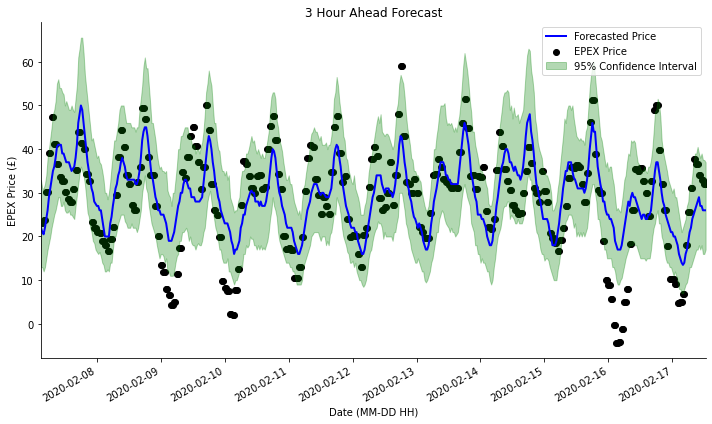

In [5]:
plot_start = starts[1] #Offset from the start date at which to begin the plot

fig, ax = plt.subplots(figsize=(10,6))
ax = Bayesian_Forecast.plot_forecast(
    fig, ax,
    epex=epex,
    datetimes=datetimes,
    plot_start=plot_start,
    plot_length=plot_length,
    horizon=horizon,
    f=forecast,
    samples=samples,
    linewidth = 2,
    credible_interval=95,
    bool_plot_all_forecasts=False)

ax = Bayesian_Forecast.forecast_ax_style(ax=ax,
    ylabel='EPEX Price (£)',
    xlabel='Date (MM-DD HH)',
    title='3 Hour Ahead Forecast',
    legend=['Forecasted Price','EPEX Price','95% Confidence Interval']
    )

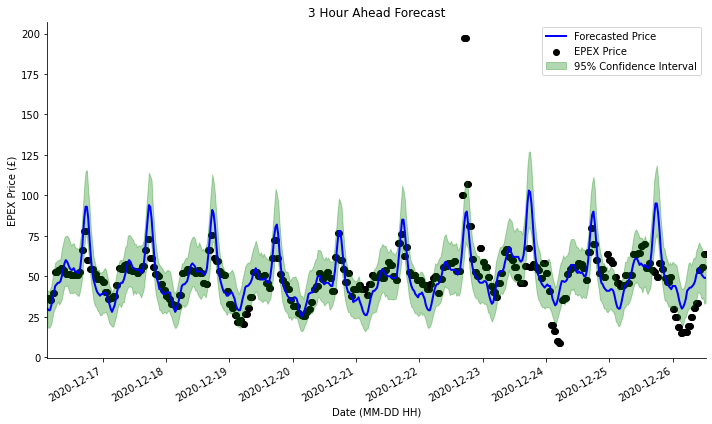

In [6]:
plot_start = starts[2] #Offset from the start date at which to begin the plot

fig, ax = plt.subplots(figsize=(10,6))
ax = Bayesian_Forecast.plot_forecast(
    fig, ax,
    epex=epex,
    datetimes=datetimes,
    plot_start=plot_start,
    plot_length=plot_length,
    horizon=horizon,
    f=forecast,
    samples=samples,
    linewidth = 2,
    credible_interval=95,
    bool_plot_all_forecasts=False)

ax = Bayesian_Forecast.forecast_ax_style(ax=ax,
    ylabel='EPEX Price (£)',
    xlabel='Date (MM-DD HH)',
    title='3 Hour Ahead Forecast',
    legend=['Forecasted Price','EPEX Price','95% Confidence Interval']
    )

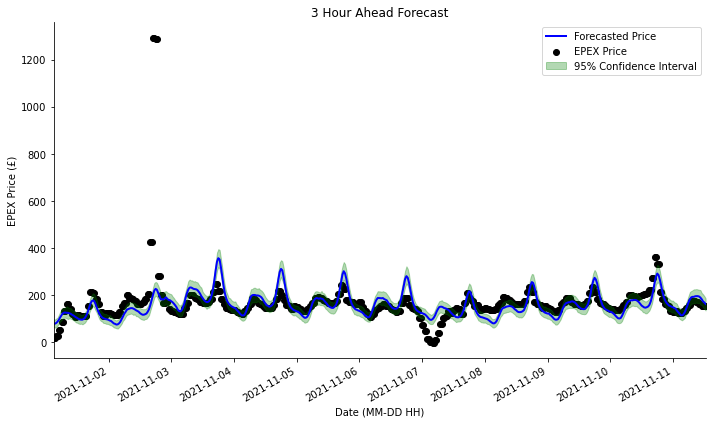

In [7]:
plot_start = starts[3] #Offset from the start date at which to begin the plot

fig, ax = plt.subplots(figsize=(10,6))
ax = Bayesian_Forecast.plot_forecast(
    fig, ax,
    epex=epex,
    datetimes=datetimes,
    plot_start=plot_start,
    plot_length=plot_length,
    horizon=horizon,
    f=forecast,
    samples=samples,
    linewidth = 2,
    credible_interval=95,
    bool_plot_all_forecasts=False)

ax = Bayesian_Forecast.forecast_ax_style(ax=ax,
    ylabel='EPEX Price (£)',
    xlabel='Date (MM-DD HH)',
    title='3 Hour Ahead Forecast',
    legend=['Forecasted Price','EPEX Price','95% Confidence Interval']
    )

# Conclusions

* Generally, the forecasting does a good job of predicting the general trend of the EPEX data.
    * It appears to do this fairly well over a large range of months and years.
* Outliers however, are poorly predicted by the model.
    * This is understandable as the prediction is based upon the previous 24 hours of EPEX data.
    * Therefore outliers, which do not correspond well to the previous data, will not be predicted. 